# Sparkify Data Science Nanodegree Capstone Project

* The goal of this data science project is to predict user churn, i.e., identify what causes users to create a subscription or cancel it respectively.
* Instead of using the pandas library, we instead use the Apache Spark framework, which is build for big data analysis running on clusters.
* The dataset used is only a fraction of the original dataset, which is about 12GB large and stored on AWS S3 (in a first step we use the small dataset; later we'll run this notebook on an AWS EMR Cluster)

# Set up Spark and other Dependencies

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, split, trim, expr, datediff, from_unixtime

from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF, StringIndexer, Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [5]:
spark = SparkSession \
    .builder \
    .appName("sparkify") \
    .getOrCreate()

In [6]:
spark

In [7]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

Run the cell below to increase width of notebook. Will be needed for SQL data operations.

In [8]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
# display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Data Exploration

To learn more about the users the follwoing questions need to answered:


## Who are the Users?

* What gender do users have?
* Where do they live?
* What are their favorite artists/songs?

## How do they interact with the Platform?

### Platform Usage

* How often do they use the platform?
* Do users who cancel their subscription don't use the platform or do they and might not like it?
* How long is an average session per user?
* What devices do they use to access the platform?

### Subscription Behavior

* How often do users switch their subscription level (paid/free)
* Is there a leading indicator that a user might cancel his paid subscriptions, e.g., high count of thumbs down



In [9]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

Since we are interested in predicting user behavior, actions recorded in the dataset need to be attributed to a userid. For records without a userId we are not able to draw conclusions on the behaviour.

In [11]:
print('{} records in the dataset have no userId. They will be dropped'.format(user_log.filter(user_log.userId == '').count()))
user_log = user_log.where(user_log.userId != '')
print('{} records in the dataset have no userId.'.format(user_log.filter(user_log.userId == '').count()))


8346 records in the dataset have no userId. They will be dropped
0 records in the dataset have no userId.


The timestamp format is not in a readable format. By creating the user defined function `get_datetime` and applying this function onto the ts column we obtain the dateTime column which has a convenient format

In [12]:
# get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# user_log = user_log.withColumn("ts_iso", get_datetime(user_log.ts)) \
#             .withColumn("registration_iso", get_datetime(user_log.registration))

# use pysparks built-in function to handel unix timestamps (divide by 1000 to convert from milliseconds)
user_log = user_log.withColumn("ts_iso", from_unixtime(user_log.ts/1000)) \
                .withColumn("registration_iso", from_unixtime(user_log.registration/1000))

The location column contains both city and state, we want to isolate both of them into seperate columns

In [13]:
user_log = user_log.withColumn('city', trim(split(user_log['location'], ',').getItem(0))) \
            .withColumn('state', trim(split(user_log['location'], ',').getItem(1)))

The userAgent columns contains information about which end-device was used to access the platform. Therfore it is usefull to learn something about the platform's users

In [14]:
user_log = user_log.withColumn('userDevice', expr("CASE WHEN lower(userAgent) LIKE '%windows%' THEN 'pc'"+
                                       "WHEN lower(userAgent) LIKE '%macintosh%' THEN 'mac'" +
                                        "WHEN lower(userAgent) LIKE '%linux%' THEN 'pc'" +
                                        "WHEN lower(userAgent) LIKE '%iphone%' THEN 'mobile'" +
                                        "WHEN lower(userAgent) LIKE '%ipad%' THEN 'mobile'" +
                                        "ELSE 'other'" +
                                        "END"))

In [15]:
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_iso='2018-10-01 02:01:57', registration_iso='2018-09-29 00:22:42', city='Bakersfield', state='CA', userDevice='pc')

## Leveraging PySpark's SQL Function for Data Exploration

In [16]:
# create temporary view against which SQL queries can be run
user_log.createOrReplaceTempView("user_log_table")

In [17]:
df_user = spark.sql("""
                    SELECT DISTINCT userId, auth, gender, city, state, userDevice
                    FROM user_log_table
                    ORDER BY userId
                    """)

In [18]:
df_user.groupBy('auth').count().show()

+---------+-----+
|     auth|count|
+---------+-----+
|Cancelled|   52|
|Logged In|  225|
+---------+-----+



In [19]:
df_user.groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  124|
|     M|  153|
+------+-----+



In [20]:
df_user.groupBy('state').count().orderBy('count', ascending=False).show(10)

+-----------+-----+
|      state|count|
+-----------+-----+
|         CA|   39|
|   NY-NJ-PA|   20|
|         TX|   19|
|         FL|   17|
|         AZ|    9|
|         MI|    8|
|         NC|    7|
|         CT|    7|
|   IL-IN-WI|    7|
|PA-NJ-DE-MD|    7|
+-----------+-----+
only showing top 10 rows



In [21]:
df_user.groupBy('userDevice').count().orderBy('count', ascending=False).show()

+----------+-----+
|userDevice|count|
+----------+-----+
|        pc|  152|
|       mac|  105|
|    mobile|   20|
+----------+-----+



In [22]:
spark.sql('''
        SELECT artist, count(*) as count
        FROM user_log_table
        WHERE artist is not null
        GROUP BY artist
        ORDER BY count(*) DESC
        ''').show(10)

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
+--------------------+-----+
only showing top 10 rows



In [23]:
spark.sql('''
        SELECT song, count(*) as count
        FROM user_log_table
        WHERE song is not null
        GROUP BY song
        ORDER BY count(*) DESC
        ''').show(10)

+--------------------+-----+
|                song|count|
+--------------------+-----+
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
+--------------------+-----+
only showing top 10 rows



### Create a table that contains user subscription behavior

Idea of the query below:

1. `errors_tab`
    * Assign each entry row number to maintain order of events (have consecutive entries with exact same timestamp)
    * Some actions are not realized because an error follows in the logs. Thus if entry $t+1$ has page "Error", set a flag for entry $t$ (Note that we want to keep the actual errors themselves, since they might be an indicator for users terminating their subscription, if they encounters a large number of errors during their paid regime)

2. `records_tab`
    * When level at $t$ is different from $t-1$ a new regime starts. Set a flag
    * When level at $t$ is "paid" and level at $t+1$ is "free", the regime at $t$ is cancelled. Set a flag
    * Choose only actions that don't result in errors

3. `regime_tab`
    * Sum up the flag set in the `records_tab`. Whenever the level changes, the `regime_count` increases by 1

4. `regime_dates`
    * The `regime_start` in the first regime is per assumption the registration date, as we don't have other data available. In later regimes $n>1$ we'll take the timestamp of the first record of regime $n$
    * In the last regime, $N$, the `regime_end` is the max. timestamp in the dataset. Else it's the timestamp of the latest record in the particular regime $n<N$

5. Final Result
    * Collect the pre-processed data
    * Obtain aggregate values per regime

**Note:** might want to break the pretabs down into seperate SQL query commands and tables to reduce complexity of statement

In [24]:
user_regime = spark.sql("""
                        with errors_tab AS(
                        SELECT
                            userId, auth, page, level, ts/1000 ts, registration/1000 registration, userDevice,
                            row_number() OVER(PARTITION BY userId ORDER BY userId, ts) record_number,
                            CASE WHEN LEAD(page) OVER(PARTITION BY userId ORDER BY userId, ts) = 'Error' THEN 1 ELSE 0 END leads_to_error
                        FROM user_log_table
                        ),


                        records_tab as(
                        SELECT
                            userId, page, level, ts, registration, userDevice, record_number,
                            CASE WHEN auth = 'Cancelled' THEN ts END date_fully_cancelled,
                            CASE WHEN LAG(level) OVER(PARTITION BY userId ORDER BY record_number) != level THEN 1 ELSE 0 END regime_change,
                            CASE WHEN LEAD(level) OVER(PARTITION BY userId ORDER BY record_number) = 'free' and level = 'paid' THEN 1 ELSE 0 END downgrade_regime
                        FROM errors_tab
                        WHERE leads_to_error = 0
                        ),


                        regime_tab AS(
                        SELECT userId, page, level, ts, registration, userDevice, record_number, date_fully_cancelled, downgrade_regime,
                            SUM(regime_change) OVER(PARTITION BY userId ORDER BY record_number)+1 regime_count
                        FROM records_tab),


                        regime_dates AS(            
                        SELECT userId, page, level, userDevice, record_number, FROM_UNIXTIME(date_fully_cancelled) date_fully_cancelled, downgrade_regime, regime_count,
                            CASE
                                WHEN regime_count = 1 THEN FROM_UNIXTIME(registration)
                                WHEN regime_count > 1 THEN FROM_UNIXTIME(first_value(ts) OVER(PARTITION BY userId, regime_count))
                            END regime_start,
                            
                            CASE
                                WHEN regime_count = last_value(regime_count) OVER(PARTITION BY userId ORDER BY ts) AND date_fully_cancelled IS NULL THEN FROM_UNIXTIME((select max(ts) FROM records_tab))
                                WHEN regime_count = last_value(regime_count) OVER(PARTITION BY userId ORDER BY ts) AND date_fully_cancelled IS NOT NULL THEN FROM_UNIXTIME(date_fully_cancelled)
                                ELSE FROM_UNIXTIME(last_value(ts) OVER(PARTITION BY userId, regime_count))
                            END regime_end
                        FROM regime_tab)

                        SELECT
                            DISTINCT userId,
                            level,
                            regime_count,
                            DATE(regime_start) regime_start,
                            DATE(regime_end) regime_end,
                            DATEDIFF(day, regime_start, regime_end) regime_lenght,
                            SUM(downgrade_regime) OVER(PARTITION BY userId, regime_count) = 1 regime_downgraded,
                            DATE(date_fully_cancelled) date_fully_cancelled,
                            count_if(page = 'NextSong') OVER(PARTITION BY userId, regime_count) next_song,
                            count_if(page = 'Thumbs Up') OVER(PARTITION BY userId, regime_count) thumbs_up,
                            count_if(page = 'Thumbs Down') OVER(PARTITION BY userId, regime_count) thumbs_down,
                            count_if(page = 'Add Friend') OVER(PARTITION BY userId, regime_count) add_friend,
                            count_if(page = 'Add to Playlist') OVER(PARTITION BY userId, regime_count) add_to_playlist,
                            count_if(page = 'Save Settings') OVER(PARTITION BY userId, regime_count) save_settings,
                            count_if(page = 'Error') OVER(PARTITION BY userId, regime_count) error,
                            count_if(page = 'Help') OVER(PARTITION BY userId, regime_count) help,
                            count_if(page = 'Roll Advert') OVER(PARTITION BY userId, regime_count) roll_advert,
                            userDevice
                        FROM regime_dates
                        ORDER BY userId, regime_count
                        
                        """)
# store results in temporary view: user_regime_table
user_regime.createOrReplaceTempView("user_regime_table")
user_regime.show(10)

23/03/15 20:32:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+-----+------------+------------+----------+-------------+-----------------+--------------------+---------+---------+-----------+----------+---------------+-------------+-----+----+-----------+----------+
|userId|level|regime_count|regime_start|regime_end|regime_lenght|regime_downgraded|date_fully_cancelled|next_song|thumbs_up|thumbs_down|add_friend|add_to_playlist|save_settings|error|help|roll_advert|userDevice|
+------+-----+------------+------------+----------+-------------+-----------------+--------------------+---------+---------+-----------+----------+---------------+-------------+-----+----+-----------+----------+
|    10| paid|           1|  2018-09-28|2018-12-03|           65|            false|                null|      673|       37|          4|        12|              9|            1|    0|   1|          1|       mac|
|   100| paid|           1|  2018-09-26|2018-12-03|           67|             true|                null|     1604|       84|         14|        32|     

### Aggregate the `user_regime_table` data per User

The aggregate table should have one row per user which contains all necessary information and can be used for ML model input.

In [25]:
user_features= spark.sql("""
                        SELECT
                            CAST(userId AS int),
                            count_if(level = 'paid') paid_regimes,
                            count_if(level = 'free') free_regimes,
                            sum(regime_lenght) membership_days,
                            count_if(regime_downgraded = 'true') downgraded_regimes,
                            CASE WHEN max(date_fully_cancelled) IS NOT NULL THEN 1 ELSE 0 END fully_cancelled,
                            sum(next_song) next_song,
                            sum(thumbs_up) thumbs_up,
                            sum(thumbs_down) thumbs_down,
                            sum(add_friend) add_friend,
                            sum(add_to_playlist) add_to_playlist,
                            sum(save_settings) save_settings,
                            sum(error) error,
                            sum(help) help,
                            sum(roll_advert) roll_advert,
                            CASE WHEN count_if(userDevice = 'mac')>0 THEN 1 ELSE 0 END device_mac,
                            CASE WHEN count_if(userDevice = 'pc')>0 THEN 1 ELSE 0 END device_pc,
                            CASE WHEN count_if(userDevice = 'mobile')>0 THEN 1 ELSE 0 END device_mobile
                        FROM
                            user_regime_table
                        GROUP BY
                            userId
                        ORDER BY
                            userId
                            
                        """)

### Calculate some aggregate averages

In [26]:
df_avg_user_regime = user_regime.where(user_regime.level == 'paid') \
                                .groupBy('regime_downgraded') \
                                .avg('regime_lenght', 'next_song', 'thumbs_up', 'thumbs_down',
                                     'add_friend', 'add_to_playlist', 'save_settings', 'error', 'roll_advert').toPandas()

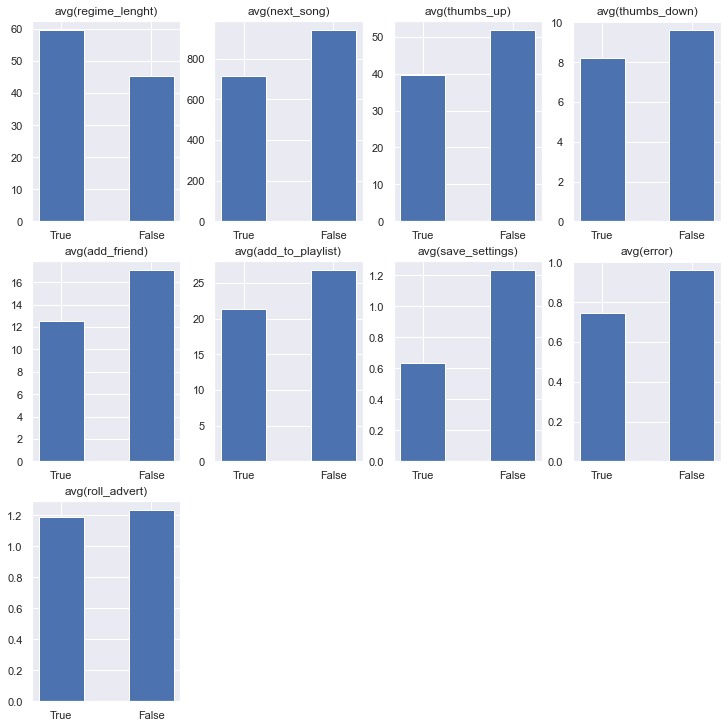

In [29]:
fig = plt.figure(figsize=(10,10), layout = 'constrained')

for i in range(1,df_avg_user_regime.shape[1]):
    
    plt.subplot(3,4,i)
    plt.bar(['True', 'False'], [df_avg_user_regime.iloc[:,i][0],df_avg_user_regime.iloc[:,i][1]], width=0.5)
    plt.title(df_avg_user_regime.columns[i])

The graph above only consideres regimes during which the level was paid.
The piture on these metrics is not quite clear: average thumb_up were higher for users who didn't downgrade.
This is in line with the assumption, that they are on average happier with the service.
However, average thumbs_down are also higher for users who didn't downgrade.

For comparison we calculate the same metrics but divide between users who cancelled their platform membership and those who didn't.

In [30]:
df_avg_lifetime = user_features.groupBy('fully_cancelled') \
                               .avg('membership_days', 'next_song', 'thumbs_up', 'thumbs_down', 
                                    'add_friend', 'add_to_playlist', 'save_settings', 'error', 'roll_advert').toPandas()

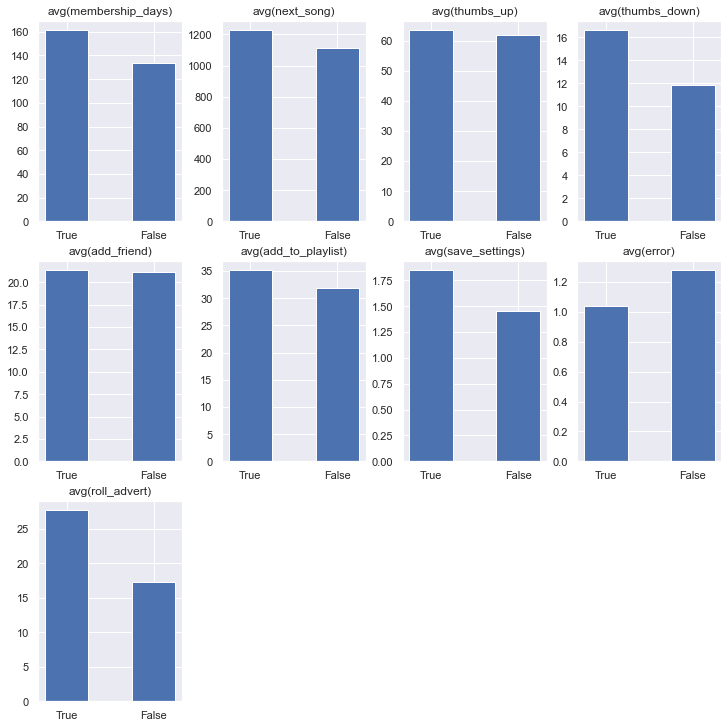

In [71]:
fig = plt.figure(figsize=(10,10), layout = 'constrained')

for i in range(1,df_avg_lifetime.shape[1]):
    
    plt.subplot(3,4,i)
    plt.bar(['True', 'False'], [df_avg_lifetime.iloc[:,i][0],df_avg_lifetime.iloc[:,i][1]], width=0.5)
    plt.title(df_avg_lifetime.columns[i])

plt.savefig('output/sparkify-comparisson-cancelled-active-users.png', dpi=600)

Here the difference between thumbs_down from user who cancelled and user who didn't cancell is significantly greater.
Furthermore, users who cancelled saw significantly more adds.

# Feature Engineering

Before we can feed the `user_features` data into a model, we need to convert it into right format

Split the user_feature data into training and validation dataset

In [34]:
rest, validation = user_features.randomSplit([0.8, 0.2], seed=42)

Combine all features into a single vector which will be normalized and used as the direct input for the models.
However, we need to drop the `fully_cancelled` columns, since its the variable we want to predict.
Furthermore, we have to drop the `device_mobile` column, because of multicolinearity considerations with `device_mac` and `device_pc`.

In [35]:
inputCols = user_features.columns
inputCols.remove('fully_cancelled')
inputCols.remove('device_mobile')

In [36]:
assembler = VectorAssembler(inputCols= inputCols, outputCol='inputFeatures')

Normalize them

In [37]:
scaler = Normalizer(inputCol="inputFeatures", outputCol="features")

# Modeling

In version 3.3.2 spark supports the following classification algorithms:

* Logistic regression
    * Binomial logistic regression
    * Multinomial logistic regression
* Decision tree classifier
* Random forest classifier
* Gradient-boosted tree classifier
* Multilayer perceptron classifier
* Linear Support Vector Machine
* One-vs-Rest classifier (a.k.a. One-vs-All)
* Naive Bayes
* Factorization machines classifier

We'll choose the four most popular:

1. [Logistic regression](#lr)
2. [Random forest classifier](#rf)
3. [Gradient boosted tree classifier](#gbt)
4. [Linear Support Vector Machine](#lsv)

To **evaluate the models**, we compute the **accuracy** and the **F1-score** for each model.

* Accuracy is defined as $$\frac{\text{no. of correct predictions}}{\text{no. of total predictions}}$$
* The F1-score combines the measure of accuracy and recall $$\frac{1}{N} \sum_{i=0}^{N-1}2\frac{|P_i\cap L_i|}{|P_i|\cdot|L_i|},$$
where $L_0, L_1, ..., L_{N-1}$ are the label sets and $P_0, P_1, ..., P_{N-1}$ the prediction sets


Details: [Spark Documentation](https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html#multilabel-classification)

In [38]:
# empty dictionary to store results
modeling_summary = {}

## Logistist Regression <a id='lr'></a>

In [39]:
# Initialize model and pipeline
lr           =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0, labelCol='fully_cancelled')
pipeline_lr  = Pipeline(stages=[assembler, scaler, lr ])

In [40]:
# Set up parameter grid
paramgrid =ParamGridBuilder()\
.addGrid(lr.regParam, [0.0, 0,1])\
.addGrid(lr.maxIter, [10])\
.build()

# Choose f1-score as evaluation metric
evaluator = MulticlassClassificationEvaluator(metricName="f1", labelCol='fully_cancelled')

# Set up cross validator
crossval = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramgrid,
                          evaluator = evaluator , 
                          numFolds=3)


In [41]:
# Fit the model
cvModel_lr = crossval.fit(rest)

23/03/15 20:33:17 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/03/15 20:33:18 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/15 20:33:18 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [42]:
# Apply model to validation set
results_lr = cvModel_lr.transform(validation)

### Accuracy of Logistic Regression Model

In [43]:
lr_TP = (results_lr.filter(results_lr.fully_cancelled == results_lr.prediction).count())
lr_totalNoPredictions = (results_lr.count())

print('Number of Correct Predictions: {}'.format(lr_TP))
print('Total Number of Predictions {}'.format(lr_totalNoPredictions))
print('Accuracy {:.4f}'.format(lr_TP/lr_totalNoPredictions))

Number of Correct Predictions: 26
Total Number of Predictions 35
Accuracy 0.7429


In [44]:
print('F1-score: {:.4f}'.format(evaluator.evaluate(cvModel_lr.transform(validation))))

F1-score: 0.6868


In [45]:
modeling_summary['lrm'] = (lr_TP/lr_totalNoPredictions, evaluator.evaluate(cvModel_lr.transform(validation)))

## Random Forest Classifier <a id='rf'></a>

In [46]:
# Initialize model and pipeline
rf           = RandomForestClassifier(labelCol='fully_cancelled')
pipeline_rf  = Pipeline(stages=[assembler, scaler, rf])

In [47]:
paramgrid_rf = ParamGridBuilder()\
.build()

evaluator = MulticlassClassificationEvaluator(metricName="f1", labelCol='fully_cancelled')

crossval = CrossValidator(estimator=pipeline_rf,  
                          estimatorParamMaps=paramgrid_rf,
                          evaluator=evaluator, 
                          numFolds=3)

In [48]:
cvModel_rf = crossval.fit(rest)

In [49]:
results_rf = cvModel_rf.transform(validation)

### Accuracy of Random Forest Classifier Model

In [50]:
rf_TP = (results_rf.filter(results_rf.fully_cancelled == results_rf.prediction).count())
rf_totalNoPredictions = (results_rf.count())

print('Number of Correct Predictions: {}'.format(rf_TP))
print('Total Number of Predictions: {}'.format(rf_totalNoPredictions))
print('Accuracy {:.4f}'.format(rf_TP/rf_totalNoPredictions))


Number of Correct Predictions: 27
Total Number of Predictions: 35
Accuracy 0.7714


In [51]:
print('F1-score: {:.4f}'.format(evaluator.evaluate(cvModel_rf.transform(validation))))

F1-score: 0.7312


In [52]:
modeling_summary['rfc'] = (rf_TP/rf_totalNoPredictions, evaluator.evaluate(cvModel_rf.transform(validation)))

## Gradient Boosted Tree Classifier <a id='gbt'></a>

In [53]:
# Initialize model and pipeline
gbt = GBTClassifier(labelCol='fully_cancelled')
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])

In [54]:
paramgrid_gbt =ParamGridBuilder()\
.build()

evaluator = MulticlassClassificationEvaluator(metricName="f1", labelCol='fully_cancelled')

crossval = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramgrid_gbt,
                          evaluator=evaluator, 
                          numFolds=3)

In [55]:
cvModel_gbt = crossval.fit(rest)

In [56]:
results_gbt = cvModel_gbt.transform(validation)

### Accuracy of Gradient Boosted Tree Classifier Model

In [57]:
gbt_TP = (results_gbt.filter(results_gbt.fully_cancelled == results_gbt.prediction).count())
gbt_totalNoPredictions = (results_gbt.count())


print('Number of Correct Predictions: {}'.format(gbt_TP))
print('Total Number of Predictions {}'.format(gbt_totalNoPredictions))
print('Accuracy {:.4f}'.format(gbt_TP/gbt_totalNoPredictions))

Number of Correct Predictions: 30
Total Number of Predictions 35
Accuracy 0.8571


In [58]:
print('F1-score: {:.4f}'.format(evaluator.evaluate(cvModel_gbt.transform(validation))))

F1-score: 0.8513


In [59]:
modeling_summary['gbt'] = (gbt_TP/gbt_totalNoPredictions, evaluator.evaluate(cvModel_gbt.transform(validation)))

## Linear Support Vector Machine <a id='lsv'></a>

In [60]:
svm = LinearSVC(labelCol='fully_cancelled')
pipeline_svm = Pipeline(stages=[assembler, scaler, svm])

In [61]:
paramgrid_svm =ParamGridBuilder()\
.build()

evaluator = MulticlassClassificationEvaluator(metricName="f1", labelCol='fully_cancelled')

crossval = CrossValidator(estimator=pipeline_svm,  
                          estimatorParamMaps=paramgrid_svm,
                          evaluator=evaluator, 
                          numFolds=3)

In [62]:
cvModel_svm=crossval.fit(rest)

In [63]:
results_svm = cvModel_svm.transform(validation)

### Accuracy of Linear Support Vector Machine Model

In [64]:
smv_TP = (results_svm.filter(results_svm.fully_cancelled == results_svm.prediction).count())
smv_totalNoPredictions = (results_svm.count())

print('Number of Correct Predictions: {}'.format(smv_TP))
print('Total Number of Predictions {}'.format(smv_totalNoPredictions))
print('Accuracy {:.4f}'.format(smv_TP/smv_totalNoPredictions))

Number of Correct Predictions: 23
Total Number of Predictions 35
Accuracy 0.6571


In [65]:
print('F1-score: {:.4f}'.format(evaluator.evaluate(cvModel_svm.transform(validation))))

F1-score: 0.5212


In [66]:
modeling_summary['svm'] = smv_TP/smv_totalNoPredictions, evaluator.evaluate(cvModel_svm.transform(validation))

# Summary 

In [67]:
df_summary = pd.DataFrame.from_dict(modeling_summary, orient='index', columns=['accuracy', 'f1-score'])
df_summary.round(4)

,accuracy,f1-score
lrm,0.7429,0.6868
rfc,0.7714,0.7312
gbt,0.8571,0.8513
svm,0.6571,0.5212


In [70]:
df_summary.to_csv('output/model_performance_results.csv')

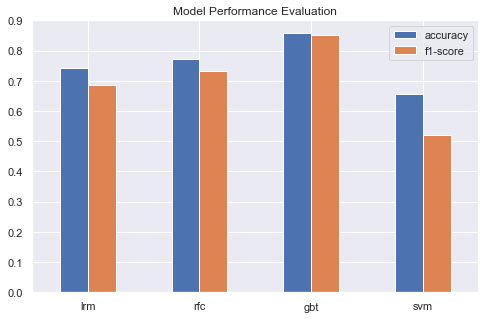

In [72]:
df_summary.plot(y=["accuracy", "f1-score"], kind="bar", rot=0, figsize=(8,5), title='Model Performance Evaluation')
plt.savefig('output/model_performance_evaluation.png', dpi=600)